In [10]:
!pip install --user raiutils


^C


In [20]:

import dice_ml
# import importlib
import dice_ml.explainer_interfaces.dice_tensorflow2 

print(dice_ml.__file__)
print(dice_ml.explainer_interfaces.__file__)
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split

dataset = helpers.load_adult_income_dataset()
target = dataset["income"] # outcome variable
train_dataset, test_dataset, _, _ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)
# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=['age', 'hours_per_week'],
                 outcome_name='income')

# Pre-trained ML model
m = dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(),
                  backend='TF2', func="ohe-min-max")
# DiCE explanation instance
exp = dice_ml.Dice(d,m)

c:\Users\astra\Documents\594bb proj\DiCE\dice_ml\__init__.py
c:\Users\astra\Documents\594bb proj\DiCE\dice_ml\explainer_interfaces\__init__.py


In [21]:
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp_gelbrich = exp.generate_counterfactuals(query_instance, total_CFs=10, desired_class="opposite")# Visualize counterfactual explanation
dice_exp_gelbrich.visualize_as_dataframe()

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,92,1
1,39,Private,HS-grad,Married,Service,White,Female,38,1
2,29,Private,Masters,Married,Blue-Collar,White,Female,64,1
3,29,Private,HS-grad,Married,Service,White,Female,87,1
4,29,Private,Prof-school,Married,Blue-Collar,White,Female,23,1
5,54,Private,HS-grad,Married,Blue-Collar,White,Female,51,1
6,29,Private,Some-college,Married,Professional,White,Female,38,1
7,62,Private,Bachelors,Married,Blue-Collar,White,Female,38,1
8,29,Private,Masters,Married,White-Collar,White,Female,38,1
9,29,Private,Masters,Married,Blue-Collar,White,Female,98,1


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import dice_ml
import tensorflow as tf

query_instance = test_dataset.drop(columns="income")[0:10]

# Generate counterfactuals using Gelbrich Distance
dice_exp_gelbrich = exp.generate_counterfactuals(query_instance, total_CFs=50, desired_class="opposite")
dice_exp_gelbrich.visualize_as_dataframe()
# Modify DiCE to use Euclidean Distance (default)
# Backup current compute_proximity_loss to force L2
orig_compute_proximity_loss = dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_proximity_loss

def compute_l2_proximity(self):
    """Compute L2 (Euclidean) distance"""
    proximity_loss = 0.0
    for i in range(self.total_CFs):
        proximity_loss += tf.norm(self.cfs[i] - self.x1, ord=2)  # Euclidean distance
    return proximity_loss / tf.cast((tf.multiply(len(self.minx[0]), self.total_CFs)), dtype=tf.float32)

def compute_l2_diversity(self):
    """Compute diversity loss using L2 distance"""
    if self.total_CFs == 1:
        return tf.constant(0.0)

    diversity_loss = 0.0
    count = 0.0
    for i in range(self.total_CFs):
        for j in range(i+1, self.total_CFs):
            count += 1.0
            diversity_loss += 1.0/(1.0 + tf.norm(self.cfs[i] - self.cfs[j], ord=2))  # Use Euclidean instead of Gelbrich
    return 1.0 - (diversity_loss/count)

def dpp_style_l2(self, submethod):
    """Compute Determinant Point Process (DPP) using L2 distances instead of Gelbrich."""
    det_entries = []
    for i in range(self.total_CFs):
        for j in range(self.total_CFs):
            det_temp_entry = tf.divide(1.0, tf.add(
                1.0, tf.norm(self.cfs[i] - self.cfs[j], ord=2)))  # Use L2 distance herequer
            if i == j:
                det_temp_entry = tf.add(det_temp_entry, 0.0001)
            det_entries.append(det_temp_entry)

    det_entries = tf.reshape(det_entries, [self.total_CFs, self.total_CFs])
    diversity_loss = tf.compat.v1.matrix_determinant(det_entries)
    return diversity_loss

dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.dpp_style = dpp_style_l2


dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_diversity_loss = compute_l2_diversity


# Override proximity loss function temporarily
dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_proximity_loss = compute_l2_proximity

# Generate counterfactuals using Euclidean distance
dice_exp_l2 = exp.generate_counterfactuals(query_instance, total_CFs=50, desired_class="opposite")
dice_exp_l2.visualize_as_dataframe()
# Restore original proximity loss function
dice_ml.explainer_interfaces.dice_tensorflow2.DiceTensorFlow2.compute_proximity_loss = orig_compute_proximity_loss


100%|██████████| 10/10 [00:45<00:00,  4.58s/it]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,44,Private,HS-grad,Married,Blue-Collar,White,Female,91,1
1,60,Private,HS-grad,Married,Service,White,Female,38,1
2,34,Private,HS-grad,Married,Blue-Collar,White,Female,46,1
3,85,Private,HS-grad,Married,Blue-Collar,White,Female,85,1
4,50,Private,HS-grad,Married,Other/Unknown,White,Female,38,1
5,29,Private,Assoc,Married,Blue-Collar,White,Female,97,1
6,29,Private,HS-grad,Married,Sales,White,Female,50,1
7,29,Private,Masters,Married,Blue-Collar,White,Female,86,1
8,29,Private,Doctorate,Married,Blue-Collar,White,Male,38,1
9,29,Private,HS-grad,Married,Blue-Collar,White,Female,83,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,54,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,1,0
1,23,Other/Unknown,Some-college,Married,White-Collar,White,Male,40,0
2,50,Other/Unknown,Some-college,Married,Service,White,Male,3,0
3,50,Other/Unknown,Some-college,Single,Other/Unknown,White,Male,19,0
4,77,Other/Unknown,Some-college,Single,Other/Unknown,White,Male,40,0
5,50,Other/Unknown,Some-college,Single,Other/Unknown,White,Male,40,0
6,30,Other/Unknown,HS-grad,Married,Other/Unknown,White,Male,40,0
7,50,Other/Unknown,Assoc,Married,Other/Unknown,White,Male,2,0
8,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Female,6,0
9,50,Other/Unknown,School,Single,Other/Unknown,White,Male,40,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Private,Bachelors,Married,Professional,White,Male,40,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,17,Private,Bachelors,Married,Other/Unknown,White,Male,40,0
1,50,Private,Bachelors,Married,Sales,White,Male,12,0
2,90,Private,School,Married,Professional,White,Male,40,0
3,50,Self-Employed,Bachelors,Married,Professional,White,Male,6,0
4,50,Private,HS-grad,Divorced,Professional,White,Male,40,0
5,50,Private,Bachelors,Married,Professional,White,Male,5,0
6,50,Private,Bachelors,Divorced,Professional,Other,Male,40,0
7,50,Private,School,Married,Professional,White,Male,40,0
8,75,Private,Bachelors,Divorced,Professional,White,Male,40,0
9,50,Private,Bachelors,Divorced,Professional,White,Male,7,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,41,Private,School,Married,Blue-Collar,White,Male,30,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,41,Private,Assoc,Married,Blue-Collar,White,Female,30,1
1,41,Other/Unknown,Prof-school,Married,Blue-Collar,White,Male,30,1
2,41,Private,Bachelors,Married,Blue-Collar,White,Male,68,1
3,68,Private,Doctorate,Married,Blue-Collar,White,Male,30,1
4,41,Private,HS-grad,Married,Blue-Collar,White,Male,92,1
5,41,Private,Masters,Married,Blue-Collar,White,Male,30,1
6,41,Private,Bachelors,Married,Blue-Collar,White,Female,30,1
7,41,Private,Some-college,Married,Blue-Collar,White,Male,75,1
8,41,Private,HS-grad,Married,Blue-Collar,White,Male,51,1
9,80,Private,Bachelors,Married,Blue-Collar,White,Male,30,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Other/Unknown,Assoc,Separated,Other/Unknown,White,Female,40,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,66,Other/Unknown,Assoc,Married,Service,White,Female,40,1
1,87,Self-Employed,Prof-school,Separated,Service,White,Female,40,1
2,28,Self-Employed,Doctorate,Separated,White-Collar,White,Female,40,1
3,47,Other/Unknown,Doctorate,Separated,Blue-Collar,White,Male,40,1
4,65,Other/Unknown,Assoc,Married,Other/Unknown,White,Female,40,1
5,28,Self-Employed,Doctorate,Married,Other/Unknown,White,Female,63,1
6,66,Other/Unknown,Assoc,Married,Other/Unknown,White,Female,40,1
7,80,Other/Unknown,Doctorate,Married,Other/Unknown,White,Female,40,1
8,63,Government,Masters,Separated,Other/Unknown,White,Female,78,1
9,28,Other/Unknown,Bachelors,Married,Other/Unknown,White,Female,40,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Private,School,Divorced,White-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Private,Prof-school,Divorced,White-Collar,White,Male,57,1
1,33,Private,Doctorate,Widowed,White-Collar,White,Male,49,1
2,33,Private,Assoc,Married,White-Collar,White,Female,40,1
3,33,Private,Prof-school,Divorced,White-Collar,White,Male,88,1
4,33,Private,Some-college,Married,White-Collar,White,Male,78,1
5,33,Private,Masters,Divorced,White-Collar,Other,Male,96,1
6,33,Private,Masters,Divorced,White-Collar,White,Male,61,1
7,56,Private,Doctorate,Divorced,Blue-Collar,White,Male,40,1
8,33,Self-Employed,Prof-school,Divorced,White-Collar,White,Male,40,1
9,33,Government,Masters,Widowed,White-Collar,White,Male,40,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Private,HS-grad,Married,Blue-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Private,Prof-school,Married,Blue-Collar,White,Male,98,1
1,33,Private,Prof-school,Married,Service,White,Male,40,1
2,33,Other/Unknown,Prof-school,Married,Blue-Collar,White,Male,40,1
3,47,Private,Bachelors,Married,Blue-Collar,White,Male,40,1
4,76,Private,Bachelors,Married,Blue-Collar,White,Male,40,1
5,33,Private,Masters,Married,Blue-Collar,White,Male,40,1
6,33,Private,Doctorate,Married,Blue-Collar,White,Female,40,1
7,33,Private,HS-grad,Married,Other/Unknown,White,Male,74,1
8,33,Private,Assoc,Married,Blue-Collar,White,Female,40,1
9,33,Private,HS-grad,Married,Sales,White,Male,93,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,18,Private,Some-college,Single,Service,White,Male,12,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57,Private,Some-college,Single,Service,White,Male,76,1
1,78,Private,Some-college,Single,Service,White,Male,79,1
2,90,Private,Some-college,Single,Service,Other,Male,79,1
3,73,Government,Doctorate,Single,Service,White,Male,39,1
4,56,Other/Unknown,Some-college,Married,Service,White,Male,31,1
5,56,Private,Some-college,Single,Service,White,Male,82,1
6,89,Private,Bachelors,Married,Service,White,Male,61,1
7,81,Government,Doctorate,Married,Service,White,Male,12,1
8,57,Private,Doctorate,Married,Service,Other,Male,12,1
9,78,Private,Bachelors,Single,Service,White,Male,66,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,26,Government,Some-college,Single,Service,Other,Female,10,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,31,Government,Some-college,Married,Service,Other,Male,78,1
1,34,Government,Doctorate,Single,Service,White,Female,75,1
2,26,Government,Some-college,Married,Service,Other,Female,55,1
3,48,Government,Some-college,Single,White-Collar,White,Male,79,1
4,61,Government,Some-college,Married,Service,Other,Male,38,1
5,72,Government,Doctorate,Single,Blue-Collar,Other,Female,56,1
6,79,Other/Unknown,Masters,Single,Service,Other,Female,94,1
7,26,Government,Some-college,Married,Professional,Other,Female,88,1
8,26,Self-Employed,Some-college,Married,Service,Other,Female,80,1
9,26,Self-Employed,Some-college,Married,Service,White,Male,61,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57,Private,School,Widowed,Service,Other,Female,30,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57,Private,Prof-school,Widowed,Service,Other,Male,91,1
1,57,Private,Assoc,Married,Service,Other,Female,30,1
2,57,Private,Doctorate,Divorced,Service,Other,Female,80,1
3,57,Private,Doctorate,Widowed,Service,Other,Male,40,1
4,57,Private,Assoc,Married,Service,Other,Female,72,1
5,57,Private,School,Married,Service,Other,Female,94,1
6,57,Self-Employed,School,Married,Service,Other,Female,56,1
7,57,Private,Doctorate,Widowed,Service,Other,Female,82,1
8,57,Private,Prof-school,Widowed,Service,White,Male,30,1
9,57,Private,Doctorate,Widowed,Service,White,Male,30,1


100%|██████████| 10/10 [00:45<00:00,  4.56s/it]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,Bachelors,Married,Blue-Collar,White,Female,74,1
1,29,Private,Prof-school,Married,Other/Unknown,White,Female,38,1
2,54,Private,HS-grad,Married,Service,White,Female,38,1
3,29,Private,HS-grad,Married,Professional,White,Female,64,1
4,30,Private,HS-grad,Married,Blue-Collar,White,Female,64,1
5,29,Private,Doctorate,Married,Blue-Collar,White,Female,89,1
6,29,Private,Doctorate,Married,White-Collar,White,Female,38,1
7,84,Private,HS-grad,Married,White-Collar,White,Female,38,1
8,29,Private,Masters,Married,Blue-Collar,White,Male,38,1
9,29,Private,Masters,Married,Blue-Collar,Other,Female,38,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,18,Other/Unknown,Some-college,Married,Other/Unknown,White,Male,40,0
1,72,Other/Unknown,Some-college,Widowed,Other/Unknown,White,Male,40,0
2,18,Other/Unknown,Some-college,Married,Other/Unknown,White,Female,40,0
3,50,Other/Unknown,Some-college,Married,Other/Unknown,White,Female,1,0
4,50,Other/Unknown,Some-college,Separated,White-Collar,White,Male,40,0
5,50,Private,Some-college,Married,Other/Unknown,White,Male,11,0
6,50,Private,Some-college,Married,Other/Unknown,White,Male,5,0
7,50,Other/Unknown,Some-college,Single,Other/Unknown,White,Male,40,0
8,22,Other/Unknown,Some-college,Married,Professional,White,Male,40,0
9,50,Private,Some-college,Married,Other/Unknown,White,Male,7,0


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Private,Bachelors,Married,Professional,White,Male,40,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,50,Private,Bachelors,Divorced,Professional,White,Male,40,0
1,50,Self-Employed,Bachelors,Separated,Professional,White,Male,40,0
2,50,Private,Bachelors,Married,Professional,White,Male,2,0
3,50,Self-Employed,Bachelors,Divorced,Professional,White,Male,40,0
4,50,Private,Some-college,Divorced,Professional,White,Male,40,0
5,20,Private,Bachelors,Married,Professional,Other,Male,40,0
6,50,Private,School,Married,Professional,Other,Male,40,0
7,50,Private,Bachelors,Married,Professional,White,Male,8,0
8,18,Private,Bachelors,Married,Professional,White,Male,40,0
9,50,Private,Bachelors,Separated,Blue-Collar,White,Male,40,0


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,41,Private,School,Married,Blue-Collar,White,Male,30,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,41,Private,Doctorate,Married,Blue-Collar,White,Male,30,1
1,41,Private,Assoc,Married,White-Collar,White,Male,30,1
2,80,Private,Masters,Married,Blue-Collar,White,Male,30,1
3,41,Private,Bachelors,Married,Blue-Collar,White,Female,30,1
4,51,Private,Doctorate,Married,Blue-Collar,White,Male,30,1
5,68,Private,Prof-school,Married,Blue-Collar,White,Male,30,1
6,41,Private,Prof-school,Married,Blue-Collar,White,Female,30,1
7,41,Private,Some-college,Married,Professional,White,Male,30,1
8,41,Other/Unknown,Bachelors,Married,Blue-Collar,White,Male,30,1
9,41,Private,School,Married,White-Collar,White,Male,66,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Other/Unknown,Assoc,Separated,Other/Unknown,White,Female,40,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,47,Other/Unknown,Doctorate,Separated,Other/Unknown,White,Male,40,1
1,44,Other/Unknown,Assoc,Married,Other/Unknown,White,Female,82,1
2,52,Private,Assoc,Married,Sales,White,Female,40,1
3,52,Other/Unknown,Assoc,Married,Sales,White,Female,40,1
4,28,Other/Unknown,Assoc,Married,Other/Unknown,White,Female,86,1
5,28,Other/Unknown,Assoc,Married,Other/Unknown,White,Female,69,1
6,28,Private,Assoc,Married,White-Collar,White,Female,40,1
7,39,Other/Unknown,Assoc,Married,Other/Unknown,White,Female,40,1
8,72,Other/Unknown,Assoc,Married,White-Collar,White,Female,40,1
9,87,Other/Unknown,Doctorate,Separated,Other/Unknown,White,Female,40,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Private,School,Divorced,White-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,89,Private,Masters,Divorced,White-Collar,White,Male,40,1
1,71,Private,Prof-school,Divorced,White-Collar,White,Male,40,1
2,86,Private,Some-college,Married,White-Collar,White,Male,40,1
3,58,Private,Some-college,Married,White-Collar,White,Male,40,1
4,33,Private,Prof-school,Divorced,White-Collar,White,Male,59,1
5,79,Private,Masters,Divorced,White-Collar,White,Male,40,1
6,41,Private,Doctorate,Divorced,White-Collar,White,Male,40,1
7,49,Private,Doctorate,Divorced,White-Collar,White,Female,40,1
8,33,Self-Employed,Assoc,Divorced,White-Collar,White,Male,58,1
9,33,Private,Prof-school,Divorced,White-Collar,White,Male,50,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Private,HS-grad,Married,Blue-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,33,Self-Employed,HS-grad,Married,Professional,White,Male,40,1
1,33,Private,HS-grad,Married,Service,White,Male,52,1
2,89,Private,HS-grad,Married,Sales,White,Male,40,1
3,49,Private,Assoc,Married,Blue-Collar,White,Male,40,1
4,50,Private,Bachelors,Married,Blue-Collar,White,Male,40,1
5,33,Private,Prof-school,Married,Blue-Collar,White,Male,61,1
6,33,Government,Doctorate,Married,Blue-Collar,White,Male,40,1
7,38,Private,HS-grad,Married,Blue-Collar,White,Male,74,1
8,65,Private,Prof-school,Married,Blue-Collar,White,Male,40,1
9,33,Private,HS-grad,Married,Blue-Collar,White,Male,91,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,18,Private,Some-college,Single,Service,White,Male,12,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,60,Private,Assoc,Widowed,Service,White,Male,57,1
1,72,Private,Masters,Single,Service,White,Female,98,1
2,60,Private,Some-college,Single,Service,White,Male,87,1
3,59,Private,Some-college,Divorced,Service,White,Male,71,1
4,54,Private,Some-college,Married,Service,White,Male,25,1
5,31,Private,Some-college,Married,Professional,White,Female,44,1
6,50,Private,Some-college,Single,Service,White,Male,85,1
7,57,Private,Some-college,Married,White-Collar,White,Male,58,1
8,90,Private,Bachelors,Divorced,Service,Other,Male,71,1
9,47,Private,Some-college,Single,Service,White,Male,80,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,26,Government,Some-college,Single,Service,Other,Female,10,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,26,Government,Doctorate,Married,Service,Other,Male,95,1
1,63,Government,Doctorate,Married,Service,Other,Female,10,1
2,26,Self-Employed,Bachelors,Married,Service,White,Female,16,1
3,26,Government,Bachelors,Married,Service,Other,Female,95,1
4,26,Self-Employed,Doctorate,Widowed,Service,Other,Male,80,1
5,43,Government,Some-college,Married,White-Collar,White,Female,10,1
6,45,Government,Doctorate,Single,Professional,Other,Female,83,1
7,26,Government,Doctorate,Widowed,Service,Other,Female,90,1
8,86,Government,Doctorate,Married,White-Collar,Other,Female,10,1
9,63,Government,Doctorate,Single,Service,Other,Female,46,1


Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57,Private,School,Widowed,Service,Other,Female,30,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,57,Private,Doctorate,Widowed,Service,Other,Female,82,1
1,57,Private,Assoc,Widowed,White-Collar,Other,Female,72,1
2,57,Other/Unknown,Doctorate,Widowed,Service,Other,Male,30,1
3,57,Private,Bachelors,Married,Service,Other,Female,89,1
4,57,Private,Doctorate,Widowed,Service,Other,Male,30,1
5,57,Private,Prof-school,Married,Service,Other,Female,30,1
6,57,Private,School,Married,Service,Other,Female,74,1
7,57,Private,Assoc,Married,Service,Other,Female,30,1
8,57,Private,Doctorate,Widowed,Service,White,Male,30,1
9,53,Private,Doctorate,Widowed,Service,Other,Male,30,1


Overall Avg L2 Distance: 2.1439671034719923
Overall Avg Gelbrich Distance: 4.848000000000001


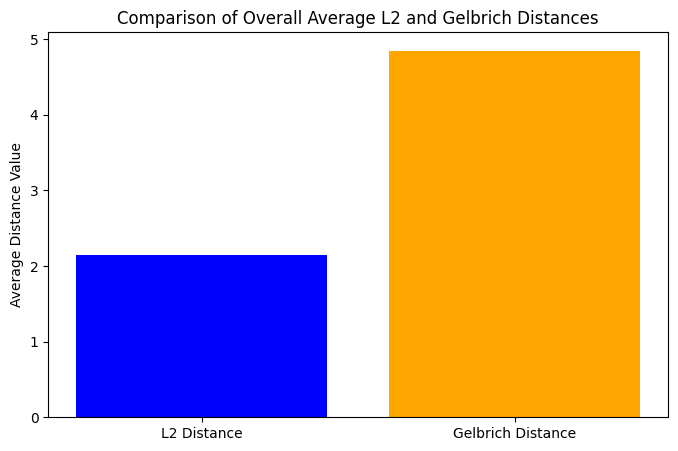

In [103]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from scipy.linalg import sqrtm  # Import matrix square root function
import dice_ml

# 🔹 Define and fit OneHotEncoder on the training dataset
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_dataset.drop(columns=['income']))  # Fit on training data (excluding target)

# 🔹 Encode the query instances
query_encoded = encoder.transform(query_instance)
query_np = query_encoded.astype(float)  # Convert to numpy (shape: (10, num_features))

# 🔹 Process each query instance separately
all_l2_distances = []
all_gelbrich_distances = []

for idx in range(len(query_instance)):  # Loop over the 10 queries

    # Extract counterfactuals for the corresponding query instance
    cf_gelbrich = dice_exp_gelbrich.cf_examples_list[idx].final_cfs_df.drop(columns=['income'])
    cf_l2 = dice_exp_l2.cf_examples_list[idx].final_cfs_df.drop(columns=['income'])

    # Encode counterfactuals
    cf_gelbrich_encoded = encoder.transform(cf_gelbrich)
    cf_l2_encoded = encoder.transform(cf_l2)

    cf_gelbrich_np = cf_gelbrich_encoded.astype(float)
    cf_l2_np = cf_l2_encoded.astype(float)

    # Get the corresponding query instance (reshape needed to match counterfactuals)
    query_instance_np = query_np[idx].reshape(1, -1)

    # 🔹 Compute L2 distances for this query instance
    l2_distances = [np.linalg.norm(cf - query_instance_np) for cf in cf_l2_np]
    avg_l2_distance = np.mean(l2_distances)

    # 🔹 Compute Gelbrich distances for this query instance
    def compute_gelbrich_distance(x_hat, x1):
        """Compute Gelbrich distance without TensorFlow Probability."""
        mean_diff = np.linalg.norm(x_hat - x1) ** 2

        def compute_covariance(matrix):
            """Compute covariance matrix manually."""
            if matrix.shape[0] > 1:  # Compute only if multiple rows exist
                mean = np.mean(matrix, axis=0, keepdims=True)
                centered_matrix = matrix - mean
                return np.dot(centered_matrix.T, centered_matrix) / (matrix.shape[0] - 1)
            else:
                return np.eye(matrix.shape[1])  # Use identity matrix if single row

        cov_x_hat = compute_covariance(x_hat)
        cov_x1 = compute_covariance(x1)

        sqrt_cov = sqrtm(np.dot(np.dot(cov_x_hat, cov_x1), cov_x_hat))

        if np.iscomplexobj(sqrt_cov):
            sqrt_cov = sqrt_cov.real  # Ensure only real values

        trace_term = np.trace(cov_x_hat + cov_x1 - 2 * sqrt_cov)

        return mean_diff + trace_term

    gelbrich_distances = [compute_gelbrich_distance(cf.reshape(1, -1), query_instance_np.reshape(1, -1)) for cf in cf_gelbrich_np]
    avg_gelbrich_distance = np.mean(gelbrich_distances)

    # Store results for all query instances
    all_l2_distances.append(avg_l2_distance)
    all_gelbrich_distances.append(avg_gelbrich_distance)

# 🔹 Compute overall averages
overall_avg_l2_distance = np.mean(all_l2_distances)
overall_avg_gelbrich_distance = np.mean(all_gelbrich_distances)

print(f"Overall Avg L2 Distance: {overall_avg_l2_distance}")
print(f"Overall Avg Gelbrich Distance: {overall_avg_gelbrich_distance}")

# 🔹 Print results
plt.figure(figsize=(8, 5))

# Data for bar chart
labels = ["L2 Distance", "Gelbrich Distance"]
values = [overall_avg_l2_distance, overall_avg_gelbrich_distance]

# Plot bar chart
plt.bar(labels, values, color=['blue', 'orange'])

# Labels and title
plt.ylabel("Average Distance Value")
plt.title("Comparison of Overall Average L2 and Gelbrich Distances")

# Show the plot
plt.show()
